# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

#FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.35KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

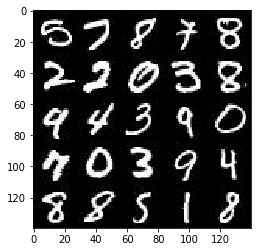

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

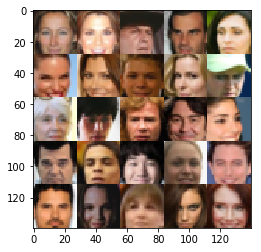

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (None))
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    i = images
    with tf.variable_scope('discriminator', reuse=reuse):
        i = tf.layers.conv2d(i, 64, 5, strides=2, padding="same")
        i = tf.layers.batch_normalization(i, training=True)
        i = tf.maximum(alpha * i, i)
        

        i = tf.layers.conv2d(i, 128, 5, strides=2, padding="same")
        i = tf.layers.batch_normalization(i, training=True)
        i = tf.maximum(alpha * i, i)
       

        i = tf.layers.conv2d(i, 256, 5, strides=2, padding="same")
        i = tf.layers.batch_normalization(i, training=True)
        i = tf.maximum(alpha * i, i)
       

        i = tf.reshape(i, (-1, 4*4*256))
        logits = tf.layers.dense(i, 1)
        out = tf.sigmoid(logits)

    return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    alpha=0.2
    with tf.variable_scope('generator', reuse=reuse):
        x = tf.layers.dense(z, 4*4*512) 
        x = tf.reshape(x, (-1,4,4,512))
        x = tf.layers.batch_normalization(x,training=is_train)
        x = tf.maximum(alpha * x, x)
       
        x = tf.layers.conv2d_transpose(x, 256, 4, strides=1, padding="valid")
        x = tf.layers.batch_normalization(x,training=is_train)
        x = tf.maximum(alpha * x, x)
    
        x = tf.layers.conv2d_transpose(x, 128, 4, strides=2, padding="same")
        x = tf.layers.batch_normalization(x,training=is_train)
        x = tf.maximum(alpha * x, x)
      
        x = tf.layers.conv2d_transpose(x, out_channel_dim, 4, strides=2, padding="same")
        

        logits = x
        out = tf.tanh(logits)
       

    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.1
    _, d_logits_real = discriminator(input_real, reuse=False)
    fake = generator(input_z, out_channel_dim, is_train=True)
   
    d_logits_fake = discriminator(fake, reuse=True)
    
    d_loss_real = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                              labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                              labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_logits_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]

    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    print_every = 25
    show_every = 100
    
    # create inputs, losses and optimizers
    input_real, input_z, lr = model_inputs(*data_shape[1:4], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # reshape and re-scale bacth image
                batch_images = batch_images.reshape(batch_size, *data_shape[1:4])
                batch_images = batch_images*2
                
                # noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # run optimizers (run generator more often than discriminator)
                _ = sess.run(d_opt, 
                             feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, 
                             feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, 
                             feed_dict={input_real: batch_images, input_z: batch_z})
                
                # print losses every 25 steps
                if steps%print_every == 0:
                    train_loss_d = d_loss.eval(feed_dict={input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval(feed_dict={input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Step {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                # show generator output everz 100 steps
                if steps%show_every == 0:
                    show_generator_output(sess, 32, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Step 25... Discriminator Loss: 2.9842... Generator Loss: 0.1726
Epoch 1/2... Step 50... Discriminator Loss: 1.6099... Generator Loss: 0.8785
Epoch 1/2... Step 75... Discriminator Loss: 1.6216... Generator Loss: 0.4402
Epoch 1/2... Step 100... Discriminator Loss: 1.6184... Generator Loss: 0.3978


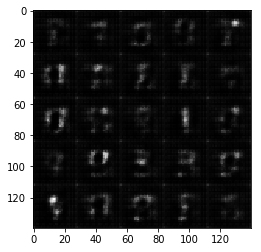

Epoch 1/2... Step 125... Discriminator Loss: 1.4690... Generator Loss: 0.6172
Epoch 1/2... Step 150... Discriminator Loss: 1.5730... Generator Loss: 0.5137
Epoch 1/2... Step 175... Discriminator Loss: 1.5929... Generator Loss: 0.5684
Epoch 1/2... Step 200... Discriminator Loss: 1.4455... Generator Loss: 0.6241


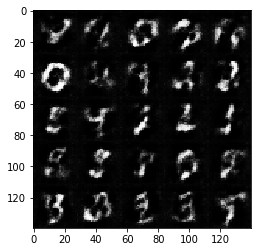

Epoch 1/2... Step 225... Discriminator Loss: 1.5036... Generator Loss: 0.5590
Epoch 1/2... Step 250... Discriminator Loss: 1.4575... Generator Loss: 0.7869
Epoch 1/2... Step 275... Discriminator Loss: 1.4097... Generator Loss: 0.5997
Epoch 1/2... Step 300... Discriminator Loss: 1.4530... Generator Loss: 0.4827


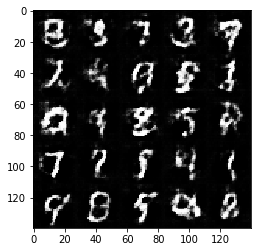

Epoch 1/2... Step 325... Discriminator Loss: 1.4987... Generator Loss: 0.6222
Epoch 1/2... Step 350... Discriminator Loss: 1.4952... Generator Loss: 0.4837
Epoch 1/2... Step 375... Discriminator Loss: 1.5006... Generator Loss: 0.5331
Epoch 1/2... Step 400... Discriminator Loss: 1.4781... Generator Loss: 0.4692


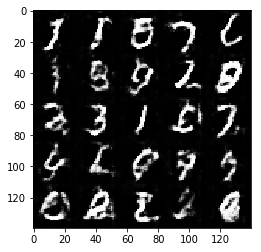

Epoch 1/2... Step 425... Discriminator Loss: 1.5598... Generator Loss: 0.6074
Epoch 1/2... Step 450... Discriminator Loss: 1.5922... Generator Loss: 0.7314
Epoch 1/2... Step 475... Discriminator Loss: 1.6374... Generator Loss: 0.3517
Epoch 1/2... Step 500... Discriminator Loss: 1.5590... Generator Loss: 0.6372


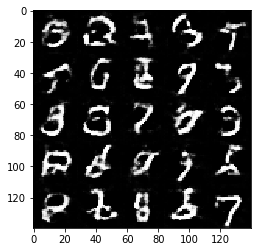

Epoch 1/2... Step 525... Discriminator Loss: 1.5225... Generator Loss: 0.6601
Epoch 1/2... Step 550... Discriminator Loss: 1.4739... Generator Loss: 0.4605
Epoch 1/2... Step 575... Discriminator Loss: 1.5459... Generator Loss: 0.5197
Epoch 1/2... Step 600... Discriminator Loss: 1.9486... Generator Loss: 0.2554


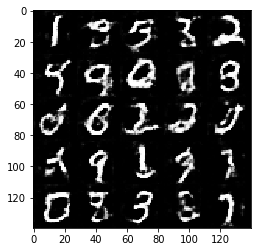

Epoch 1/2... Step 625... Discriminator Loss: 1.5414... Generator Loss: 0.3907
Epoch 1/2... Step 650... Discriminator Loss: 1.6391... Generator Loss: 0.8016
Epoch 1/2... Step 675... Discriminator Loss: 1.5242... Generator Loss: 0.5219
Epoch 1/2... Step 700... Discriminator Loss: 1.5985... Generator Loss: 0.3673


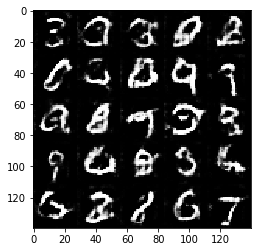

Epoch 1/2... Step 725... Discriminator Loss: 1.5539... Generator Loss: 0.3962
Epoch 1/2... Step 750... Discriminator Loss: 1.4697... Generator Loss: 0.7218
Epoch 1/2... Step 775... Discriminator Loss: 1.6374... Generator Loss: 0.7790
Epoch 1/2... Step 800... Discriminator Loss: 1.5909... Generator Loss: 0.6401


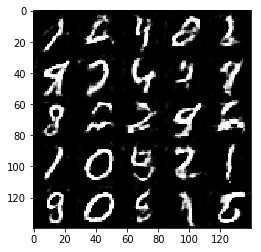

Epoch 1/2... Step 825... Discriminator Loss: 1.6197... Generator Loss: 0.5900
Epoch 1/2... Step 850... Discriminator Loss: 1.5465... Generator Loss: 0.7054
Epoch 1/2... Step 875... Discriminator Loss: 1.5736... Generator Loss: 0.4015
Epoch 1/2... Step 900... Discriminator Loss: 1.4719... Generator Loss: 0.4611


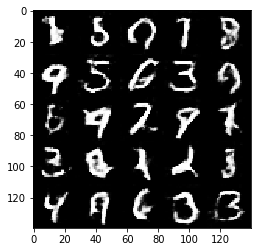

Epoch 1/2... Step 925... Discriminator Loss: 1.4230... Generator Loss: 0.5329
Epoch 2/2... Step 950... Discriminator Loss: 1.7543... Generator Loss: 0.3016
Epoch 2/2... Step 975... Discriminator Loss: 1.4765... Generator Loss: 0.5759
Epoch 2/2... Step 1000... Discriminator Loss: 1.4811... Generator Loss: 0.4826


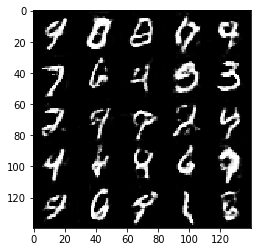

Epoch 2/2... Step 1025... Discriminator Loss: 1.4511... Generator Loss: 0.5796
Epoch 2/2... Step 1050... Discriminator Loss: 1.3568... Generator Loss: 0.5558
Epoch 2/2... Step 1075... Discriminator Loss: 1.5206... Generator Loss: 0.7300
Epoch 2/2... Step 1100... Discriminator Loss: 1.5342... Generator Loss: 0.4153


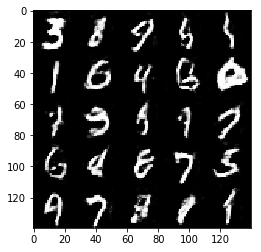

Epoch 2/2... Step 1125... Discriminator Loss: 1.4411... Generator Loss: 0.5154
Epoch 2/2... Step 1150... Discriminator Loss: 1.5296... Generator Loss: 0.5263
Epoch 2/2... Step 1175... Discriminator Loss: 1.5781... Generator Loss: 0.5180
Epoch 2/2... Step 1200... Discriminator Loss: 1.5435... Generator Loss: 0.4254


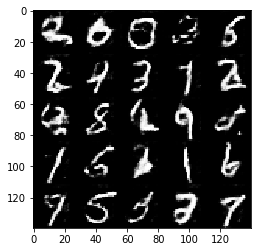

Epoch 2/2... Step 1225... Discriminator Loss: 1.5597... Generator Loss: 0.7070
Epoch 2/2... Step 1250... Discriminator Loss: 1.4751... Generator Loss: 0.4813
Epoch 2/2... Step 1275... Discriminator Loss: 1.5415... Generator Loss: 0.3956
Epoch 2/2... Step 1300... Discriminator Loss: 1.5072... Generator Loss: 0.3961


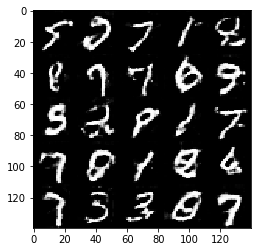

Epoch 2/2... Step 1325... Discriminator Loss: 1.4492... Generator Loss: 0.4857
Epoch 2/2... Step 1350... Discriminator Loss: 1.6471... Generator Loss: 0.3455
Epoch 2/2... Step 1375... Discriminator Loss: 1.3897... Generator Loss: 0.5301
Epoch 2/2... Step 1400... Discriminator Loss: 1.7342... Generator Loss: 0.3092


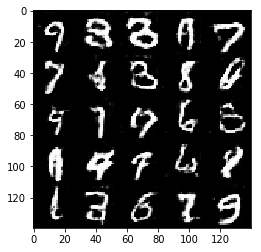

Epoch 2/2... Step 1425... Discriminator Loss: 1.4356... Generator Loss: 0.4598
Epoch 2/2... Step 1450... Discriminator Loss: 1.5499... Generator Loss: 0.3974
Epoch 2/2... Step 1475... Discriminator Loss: 1.4984... Generator Loss: 0.5283
Epoch 2/2... Step 1500... Discriminator Loss: 1.6437... Generator Loss: 0.3418


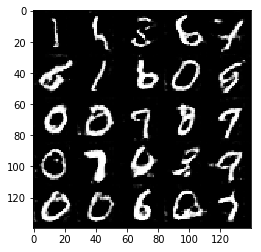

Epoch 2/2... Step 1525... Discriminator Loss: 1.5674... Generator Loss: 0.7877
Epoch 2/2... Step 1550... Discriminator Loss: 1.8550... Generator Loss: 0.2823
Epoch 2/2... Step 1575... Discriminator Loss: 1.9685... Generator Loss: 0.2557
Epoch 2/2... Step 1600... Discriminator Loss: 1.4226... Generator Loss: 0.5730


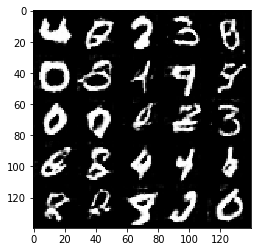

Epoch 2/2... Step 1625... Discriminator Loss: 1.4395... Generator Loss: 0.6515
Epoch 2/2... Step 1650... Discriminator Loss: 1.6719... Generator Loss: 0.6434
Epoch 2/2... Step 1675... Discriminator Loss: 1.4925... Generator Loss: 0.5916
Epoch 2/2... Step 1700... Discriminator Loss: 1.3400... Generator Loss: 0.6144


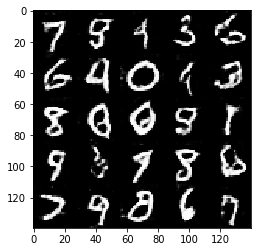

Epoch 2/2... Step 1725... Discriminator Loss: 1.3662... Generator Loss: 0.5519
Epoch 2/2... Step 1750... Discriminator Loss: 2.1156... Generator Loss: 0.2542
Epoch 2/2... Step 1775... Discriminator Loss: 1.4383... Generator Loss: 0.5462
Epoch 2/2... Step 1800... Discriminator Loss: 1.7608... Generator Loss: 0.3078


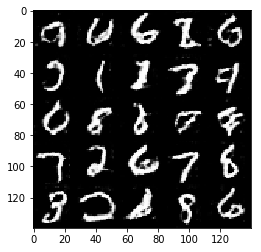

Epoch 2/2... Step 1825... Discriminator Loss: 1.7094... Generator Loss: 0.3247
Epoch 2/2... Step 1850... Discriminator Loss: 1.4169... Generator Loss: 0.4637


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Step 25... Discriminator Loss: 1.1497... Generator Loss: 1.8217
Epoch 1/1... Step 50... Discriminator Loss: 2.3188... Generator Loss: 0.2902
Epoch 1/1... Step 75... Discriminator Loss: 1.4175... Generator Loss: 0.5481
Epoch 1/1... Step 100... Discriminator Loss: 1.0187... Generator Loss: 1.3116


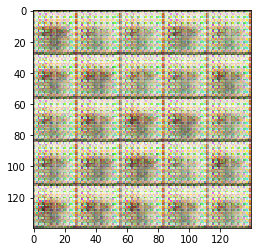

Epoch 1/1... Step 125... Discriminator Loss: 0.9270... Generator Loss: 1.1997
Epoch 1/1... Step 150... Discriminator Loss: 1.6048... Generator Loss: 0.9527
Epoch 1/1... Step 175... Discriminator Loss: 1.5611... Generator Loss: 0.6119
Epoch 1/1... Step 200... Discriminator Loss: 1.8440... Generator Loss: 0.4364


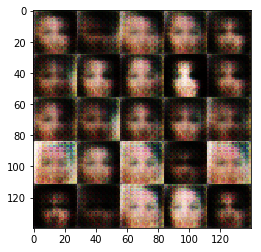

Epoch 1/1... Step 225... Discriminator Loss: 1.6103... Generator Loss: 0.5241
Epoch 1/1... Step 250... Discriminator Loss: 1.5634... Generator Loss: 0.5007
Epoch 1/1... Step 275... Discriminator Loss: 1.5280... Generator Loss: 0.5519
Epoch 1/1... Step 300... Discriminator Loss: 1.5463... Generator Loss: 0.5539


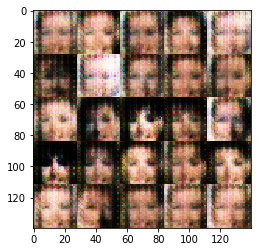

Epoch 1/1... Step 325... Discriminator Loss: 1.6201... Generator Loss: 0.4869
Epoch 1/1... Step 350... Discriminator Loss: 1.6344... Generator Loss: 0.4614
Epoch 1/1... Step 375... Discriminator Loss: 1.5968... Generator Loss: 0.5428
Epoch 1/1... Step 400... Discriminator Loss: 1.6331... Generator Loss: 0.4760


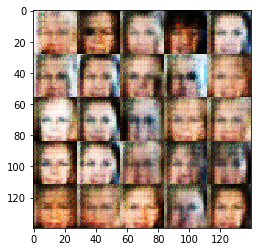

Epoch 1/1... Step 425... Discriminator Loss: 1.7075... Generator Loss: 0.4464
Epoch 1/1... Step 450... Discriminator Loss: 1.6557... Generator Loss: 0.4732
Epoch 1/1... Step 475... Discriminator Loss: 1.6763... Generator Loss: 0.4504
Epoch 1/1... Step 500... Discriminator Loss: 1.6399... Generator Loss: 0.4845


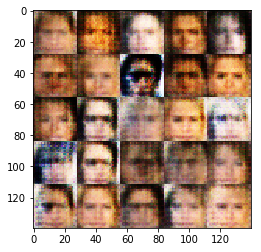

Epoch 1/1... Step 525... Discriminator Loss: 1.6438... Generator Loss: 0.4558
Epoch 1/1... Step 550... Discriminator Loss: 1.5839... Generator Loss: 0.4954
Epoch 1/1... Step 575... Discriminator Loss: 1.5826... Generator Loss: 0.5207
Epoch 1/1... Step 600... Discriminator Loss: 1.5861... Generator Loss: 0.4918


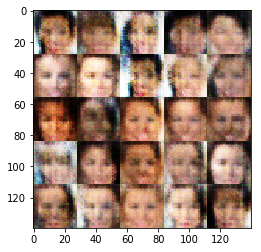

Epoch 1/1... Step 625... Discriminator Loss: 1.5341... Generator Loss: 0.5379
Epoch 1/1... Step 650... Discriminator Loss: 1.6250... Generator Loss: 0.5027
Epoch 1/1... Step 675... Discriminator Loss: 1.5691... Generator Loss: 0.4891
Epoch 1/1... Step 700... Discriminator Loss: 1.6330... Generator Loss: 0.4691


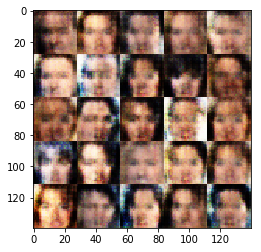

Epoch 1/1... Step 725... Discriminator Loss: 1.5701... Generator Loss: 0.5431
Epoch 1/1... Step 750... Discriminator Loss: 1.6634... Generator Loss: 0.4630
Epoch 1/1... Step 775... Discriminator Loss: 1.5748... Generator Loss: 0.4946
Epoch 1/1... Step 800... Discriminator Loss: 1.4993... Generator Loss: 0.5503


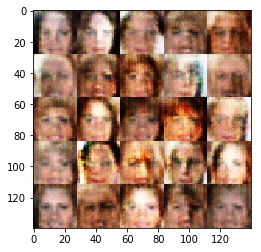

Epoch 1/1... Step 825... Discriminator Loss: 1.5443... Generator Loss: 0.5069
Epoch 1/1... Step 850... Discriminator Loss: 1.6141... Generator Loss: 0.4719
Epoch 1/1... Step 875... Discriminator Loss: 1.6385... Generator Loss: 0.4830
Epoch 1/1... Step 900... Discriminator Loss: 1.5547... Generator Loss: 0.4960


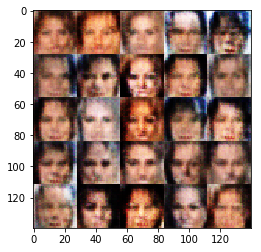

Epoch 1/1... Step 925... Discriminator Loss: 1.5561... Generator Loss: 0.5413
Epoch 1/1... Step 950... Discriminator Loss: 1.5418... Generator Loss: 0.4945
Epoch 1/1... Step 975... Discriminator Loss: 1.6263... Generator Loss: 0.4550
Epoch 1/1... Step 1000... Discriminator Loss: 1.5606... Generator Loss: 0.5039


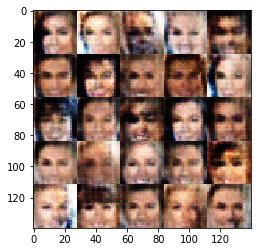

Epoch 1/1... Step 1025... Discriminator Loss: 1.6733... Generator Loss: 0.4445
Epoch 1/1... Step 1050... Discriminator Loss: 1.5944... Generator Loss: 0.4779
Epoch 1/1... Step 1075... Discriminator Loss: 1.5691... Generator Loss: 0.5024
Epoch 1/1... Step 1100... Discriminator Loss: 1.5295... Generator Loss: 0.4990


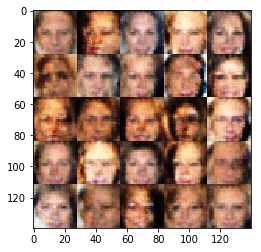

Epoch 1/1... Step 1125... Discriminator Loss: 1.6277... Generator Loss: 0.4666
Epoch 1/1... Step 1150... Discriminator Loss: 1.6405... Generator Loss: 0.4835
Epoch 1/1... Step 1175... Discriminator Loss: 1.5888... Generator Loss: 0.5087
Epoch 1/1... Step 1200... Discriminator Loss: 1.5810... Generator Loss: 0.4994


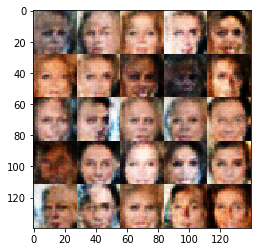

Epoch 1/1... Step 1225... Discriminator Loss: 1.6051... Generator Loss: 0.4867
Epoch 1/1... Step 1250... Discriminator Loss: 1.5353... Generator Loss: 0.5228
Epoch 1/1... Step 1275... Discriminator Loss: 1.5679... Generator Loss: 0.4852
Epoch 1/1... Step 1300... Discriminator Loss: 1.5382... Generator Loss: 0.5291


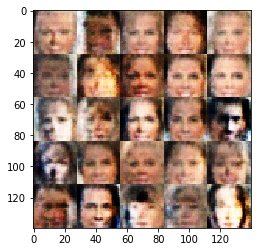

Epoch 1/1... Step 1325... Discriminator Loss: 1.5587... Generator Loss: 0.4840
Epoch 1/1... Step 1350... Discriminator Loss: 1.5566... Generator Loss: 0.5081
Epoch 1/1... Step 1375... Discriminator Loss: 1.5830... Generator Loss: 0.4991
Epoch 1/1... Step 1400... Discriminator Loss: 1.6057... Generator Loss: 0.4759


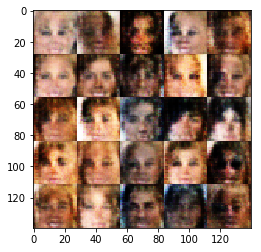

Epoch 1/1... Step 1425... Discriminator Loss: 1.5708... Generator Loss: 0.5036
Epoch 1/1... Step 1450... Discriminator Loss: 1.5385... Generator Loss: 0.5195
Epoch 1/1... Step 1475... Discriminator Loss: 1.5687... Generator Loss: 0.5357
Epoch 1/1... Step 1500... Discriminator Loss: 1.5607... Generator Loss: 0.4964


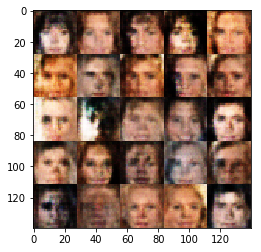

Epoch 1/1... Step 1525... Discriminator Loss: 1.5459... Generator Loss: 0.5153
Epoch 1/1... Step 1550... Discriminator Loss: 1.5586... Generator Loss: 0.5267
Epoch 1/1... Step 1575... Discriminator Loss: 1.5389... Generator Loss: 0.5437
Epoch 1/1... Step 1600... Discriminator Loss: 1.5618... Generator Loss: 0.5271


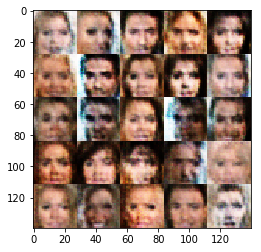

Epoch 1/1... Step 1625... Discriminator Loss: 1.5488... Generator Loss: 0.5109
Epoch 1/1... Step 1650... Discriminator Loss: 1.5674... Generator Loss: 0.5006
Epoch 1/1... Step 1675... Discriminator Loss: 1.5813... Generator Loss: 0.5172
Epoch 1/1... Step 1700... Discriminator Loss: 1.5503... Generator Loss: 0.4934


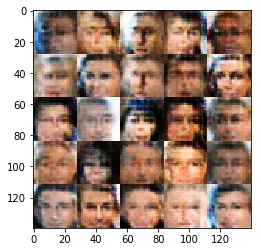

Epoch 1/1... Step 1725... Discriminator Loss: 1.5787... Generator Loss: 0.5012
Epoch 1/1... Step 1750... Discriminator Loss: 1.5178... Generator Loss: 0.5267
Epoch 1/1... Step 1775... Discriminator Loss: 1.6007... Generator Loss: 0.4945
Epoch 1/1... Step 1800... Discriminator Loss: 1.5481... Generator Loss: 0.5077


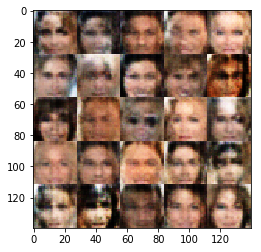

Epoch 1/1... Step 1825... Discriminator Loss: 1.4909... Generator Loss: 0.5516
Epoch 1/1... Step 1850... Discriminator Loss: 1.5482... Generator Loss: 0.4912
Epoch 1/1... Step 1875... Discriminator Loss: 1.5721... Generator Loss: 0.4924
Epoch 1/1... Step 1900... Discriminator Loss: 1.5735... Generator Loss: 0.4891


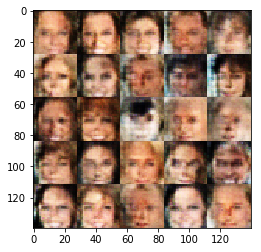

Epoch 1/1... Step 1925... Discriminator Loss: 1.5497... Generator Loss: 0.5352
Epoch 1/1... Step 1950... Discriminator Loss: 1.5464... Generator Loss: 0.4912
Epoch 1/1... Step 1975... Discriminator Loss: 1.5424... Generator Loss: 0.5298
Epoch 1/1... Step 2000... Discriminator Loss: 1.5459... Generator Loss: 0.5293


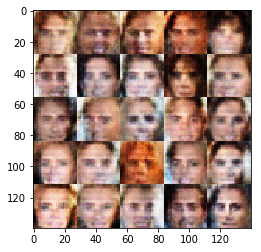

Epoch 1/1... Step 2025... Discriminator Loss: 1.5465... Generator Loss: 0.5190
Epoch 1/1... Step 2050... Discriminator Loss: 1.5596... Generator Loss: 0.5064
Epoch 1/1... Step 2075... Discriminator Loss: 1.5255... Generator Loss: 0.5100
Epoch 1/1... Step 2100... Discriminator Loss: 1.5486... Generator Loss: 0.5240


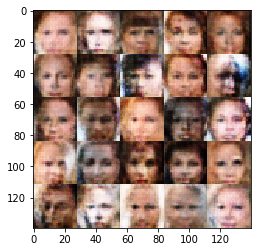

Epoch 1/1... Step 2125... Discriminator Loss: 1.5221... Generator Loss: 0.5405
Epoch 1/1... Step 2150... Discriminator Loss: 1.5651... Generator Loss: 0.5058
Epoch 1/1... Step 2175... Discriminator Loss: 1.5555... Generator Loss: 0.5008
Epoch 1/1... Step 2200... Discriminator Loss: 1.5753... Generator Loss: 0.4806


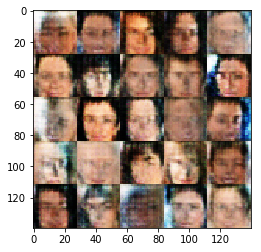

Epoch 1/1... Step 2225... Discriminator Loss: 1.5450... Generator Loss: 0.5030
Epoch 1/1... Step 2250... Discriminator Loss: 1.5714... Generator Loss: 0.4958
Epoch 1/1... Step 2275... Discriminator Loss: 1.5481... Generator Loss: 0.5505
Epoch 1/1... Step 2300... Discriminator Loss: 1.5591... Generator Loss: 0.5297


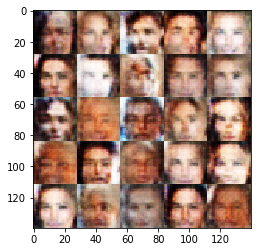

Epoch 1/1... Step 2325... Discriminator Loss: 1.5720... Generator Loss: 0.5025
Epoch 1/1... Step 2350... Discriminator Loss: 1.5731... Generator Loss: 0.4866
Epoch 1/1... Step 2375... Discriminator Loss: 1.5799... Generator Loss: 0.5016
Epoch 1/1... Step 2400... Discriminator Loss: 1.5439... Generator Loss: 0.4971


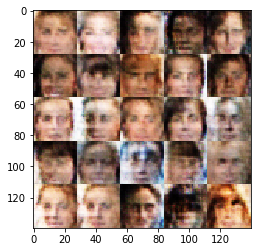

Epoch 1/1... Step 2425... Discriminator Loss: 1.5623... Generator Loss: 0.5220
Epoch 1/1... Step 2450... Discriminator Loss: 1.5598... Generator Loss: 0.5168
Epoch 1/1... Step 2475... Discriminator Loss: 1.5472... Generator Loss: 0.4987
Epoch 1/1... Step 2500... Discriminator Loss: 1.5666... Generator Loss: 0.5228


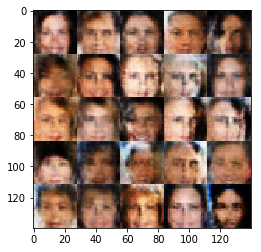

Epoch 1/1... Step 2525... Discriminator Loss: 1.5325... Generator Loss: 0.5153
Epoch 1/1... Step 2550... Discriminator Loss: 1.5446... Generator Loss: 0.4772
Epoch 1/1... Step 2575... Discriminator Loss: 1.4972... Generator Loss: 0.5376
Epoch 1/1... Step 2600... Discriminator Loss: 1.5559... Generator Loss: 0.4908


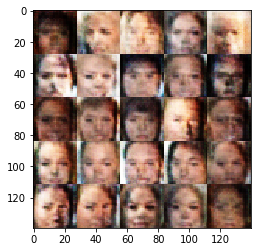

Epoch 1/1... Step 2625... Discriminator Loss: 1.5694... Generator Loss: 0.4962
Epoch 1/1... Step 2650... Discriminator Loss: 1.5532... Generator Loss: 0.4941
Epoch 1/1... Step 2675... Discriminator Loss: 1.5687... Generator Loss: 0.5016
Epoch 1/1... Step 2700... Discriminator Loss: 1.5385... Generator Loss: 0.5432


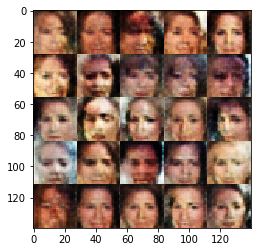

Epoch 1/1... Step 2725... Discriminator Loss: 1.5059... Generator Loss: 0.5340
Epoch 1/1... Step 2750... Discriminator Loss: 1.5680... Generator Loss: 0.5120
Epoch 1/1... Step 2775... Discriminator Loss: 1.5596... Generator Loss: 0.5069
Epoch 1/1... Step 2800... Discriminator Loss: 1.5334... Generator Loss: 0.5103


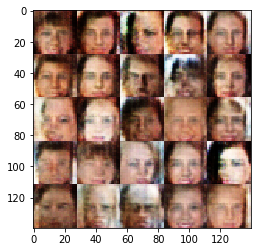

Epoch 1/1... Step 2825... Discriminator Loss: 1.5259... Generator Loss: 0.5251
Epoch 1/1... Step 2850... Discriminator Loss: 1.5279... Generator Loss: 0.5212
Epoch 1/1... Step 2875... Discriminator Loss: 1.5270... Generator Loss: 0.5523
Epoch 1/1... Step 2900... Discriminator Loss: 1.5524... Generator Loss: 0.4783


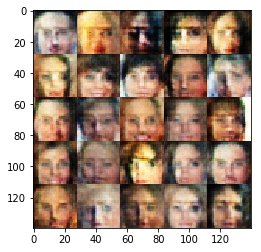

Epoch 1/1... Step 2925... Discriminator Loss: 1.5373... Generator Loss: 0.5021
Epoch 1/1... Step 2950... Discriminator Loss: 1.5706... Generator Loss: 0.5177
Epoch 1/1... Step 2975... Discriminator Loss: 1.5382... Generator Loss: 0.5247
Epoch 1/1... Step 3000... Discriminator Loss: 1.5430... Generator Loss: 0.5135


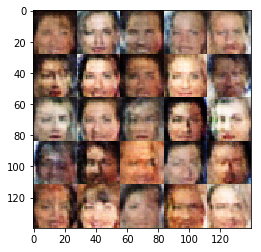

Epoch 1/1... Step 3025... Discriminator Loss: 1.5368... Generator Loss: 0.5290
Epoch 1/1... Step 3050... Discriminator Loss: 1.5522... Generator Loss: 0.5210
Epoch 1/1... Step 3075... Discriminator Loss: 1.5404... Generator Loss: 0.5089
Epoch 1/1... Step 3100... Discriminator Loss: 1.5528... Generator Loss: 0.4891


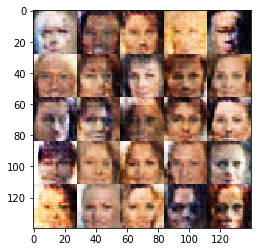

Epoch 1/1... Step 3125... Discriminator Loss: 1.5513... Generator Loss: 0.5057
Epoch 1/1... Step 3150... Discriminator Loss: 1.5439... Generator Loss: 0.5167


In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.